# Gold Industry Analysis¶

**Project goal**: to prepare a prototype of a machine learning model for "X" company. The model should predict the recovery rate of gold from a gold-bearing ore. The essence of the model is to help optimize production so as not to launch a plant with unprofitable characteristics.

**Data**: dataset with mining and cleaning parameters.

**Note:**

**I.** When the mined ore undergoes primary processing, a crushed mixture is obtained. It is sent to flotation (beneficiation) and two-stage purification.

**II. Data Description:**
1. Technological process
- Rougher feed - raw material
- Rougher additions (or reagent additions) - flotation reagents: Xanthate, Sulphate, Depressant
- Rougher process (English "rough process") - flotation
- Rougher tails - tailings
- Float banks - flotation unit
- Cleaner process - cleaning
- Rougher Au - rough gold concentrate
- Final Au - final gold concentrate
2. Stage parameters
- air amount - air volume
- fluid levels - fluid level
- feed size - raw material granule size
- feed rate - feed rate

**III. Features names:**

The name of the signs should be as follows:
[stage]. [parameter_type]. [parameter_name]
Example: rougher.input.feed_ag

Possible values for the [stage] block:
- rougher - flotation
- primary_cleaner - primary cleanup
- secondary_cleaner - secondary cleanup
- final - final characteristics

Possible values for the [parameter_type] block:
- input - raw material parameters
- output - product parameters
- state - parameters characterizing the current state of the stage
- calculation - calculated characteristics

**IV. Efficiency calculation:**

There is need to simulate the process of recovering gold from gold ore.
The enrichment efficiency is calculated by the formula:
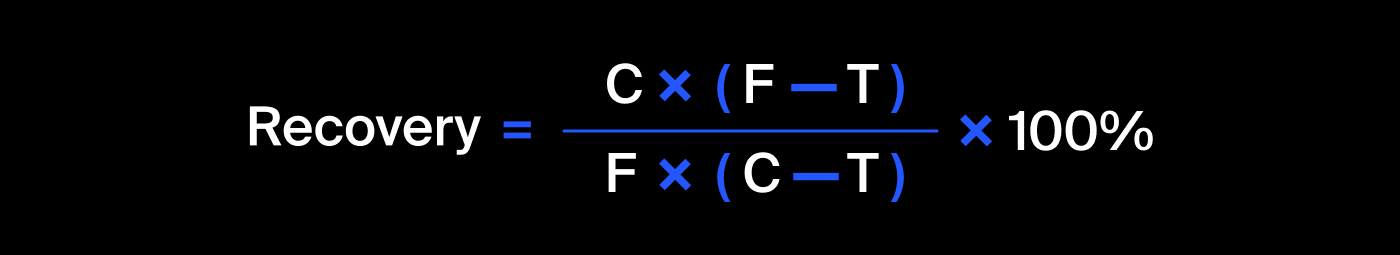
where:
- C is the proportion of gold in the concentrate after flotation / refining;
- F is the proportion of gold in the raw material / concentrate before flotation / refining;
- T is the proportion of gold in tailings after flotation / cleaning.
To predict the ratio, ther is need to find the proportion of gold in concentrates and tailings. Moreover, not only the final product is important, but also the rough concentrate.

**V. Quality metric:**

To solve the problem, a new quality metric will be used - sMAPE (Symmetric Mean Absolute Percentage Error).
It is necessary to predict two values at once:
1. rough concentrate dressing efficiency: rougher.output.recovery;
2.  concentration efficiency of the final concentrate final.output.recovery.

The final metric should consist of two values:
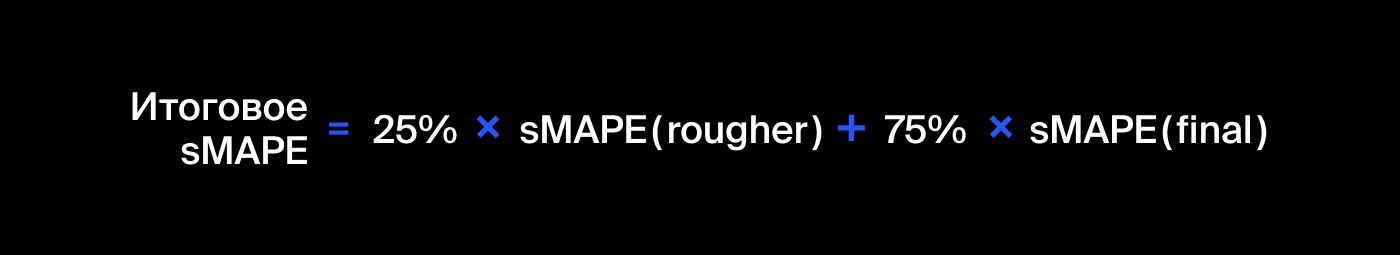

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploring-data" data-toc-modified-id="Exploring-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploring data</a></span></li><li><span><a href="#Enrichment-efficiency-calculation" data-toc-modified-id="Enrichment-efficiency-calculation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Enrichment efficiency calculation</a></span></li><li><span><a href="#Analysis-of-features-that-are-not-available-in-the-test-sample" data-toc-modified-id="Analysis-of-features-that-are-not-available-in-the-test-sample-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis of features that are not available in the test sample</a></span></li><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data preprocessing</a></span></li><li><span><a href="#Analysis-of-Au,-Ag-and-Pb-concentrations" data-toc-modified-id="Analysis-of-Au,-Ag-and-Pb-concentrations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analysis of Au, Ag and Pb concentrations</a></span></li><li><span><a href="#Raw-material-granules'-size-distribution" data-toc-modified-id="Raw-material-granules'-size-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Raw material granules' size distribution</a></span></li><li><span><a href="#Study-of-the-total-concentration-of-all-substances¶" data-toc-modified-id="Study-of-the-total-concentration-of-all-substances¶-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Study of the total concentration of all substances¶</a></span></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Model training</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Exploring data

**Loading the required libraries and datasets**

In [21]:
# libraries

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.scorer import make_scorer
from sklearn.dummy import DummyRegressor

# mute notifications
import warnings
warnings.filterwarnings('ignore')

# import data
# train dataset
train = pd.read_csv('gold_recovery_train_new.csv')
# test dataset
test = pd.read_csv('gold_recovery_test_new.csv')
# full dataset
full = pd.read_csv('gold_recovery_full_new.csv')

In [22]:
# Function for exploring data
def exploring(dataset):
    print(dataset.info())
    display(dataset.describe())
    print(dataset.isna().sum())
    print(dataset.duplicated().sum())

**Train dataset:**

In [23]:
train.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [24]:
exploring(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64
0


So, as can be seen:

- the training dataset contains 14149 observations and 87 variables;
- all variables (except for the date, which is the index in this table) are of the type of real numbers (float64);
- some variables have a small number of missing values;
- however, there are 211 missing values in the 'final.output.concentrate_sol' variable;
- as for duplicates, they were not found in the training dataset.

**Test dataset:**

In [25]:
test.head(5)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [26]:
exploring(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

Analysis of the test dataset showed the following:

- there are a total of 5290 observations and 53 variables in the dataset;
- all variables (except for the date, which is the index in this table) are of the type of real numbers (float64);
- some variables have a small number of missing values (no more than 10);
- the variables 'rougher.input.feed_sol' and 'rougher.input.floatbank11_xanthate' contain 21 and 25 missing values, respectively;
- as in the previous dataset, no duplicates were found.

**Initial data (full dataset):**

In [27]:
full.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [28]:
exploring(full)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64
0


Initial data information:

- in total contains 19439 observations and 87 variables;
- all variables (except for the date, which is the index in this table) are of the type of real numbers (float64);
- some variables contain a small number of missing values;
- the variable 'final.output.concentrate_sol' contains 211 missing values;
- there are no duplicated lines.

## Enrichment efficiency calculation

Let's check that the enrichment efficiency is calculated correctly. To do this, I will calculate it on the training set and find the MAE between my calculations and the variable's value.

In [29]:
# using the provided formula for self-calculations of Recovery:
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

train['recovery_check'] = (C * (F - T)) / (F * (C - T)) * 100
train['recovery_check'].head(5)

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: recovery_check, dtype: float64

In order to correlate the independently calculated Recovery value with the 'rougher.output.recovery' indicator already in the table, let's use the MAE metric:

In [30]:
mae = mean_absolute_error(train['rougher.output.recovery'], 
                          train['recovery_check'])
print('MAE:', mae)

MAE: 9.682896147825551e-15


The value of the mean absolute error is represented by a very small number, therefore, it can be said that the difference between the independently calculated indicator of the efficiency of enrichment and the calculation presented in the data is small. That is, the calculations were performed correctly.

## Analysis of features that are not available in the test sample

Let's look at the samples' shapes:

In [31]:
print(train.shape)
print(test.shape)

(14149, 88)
(5290, 53)


As can be seen, the test sample lacks 35 features that are observed in the training dataset. Let's see what these features are:

In [32]:
missing_col = set(train) - set(test)
missing_col

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'recovery_check',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',


So, in the test sample, in contrast to the training sample, there are no variables with the parameter type 'output' and 'calculation'. That is, in the test sample, some calculation and output characteristics of the process are not available, since they cannot be obtained / measured during the execution of the technological process.

## Data preprocessing

**1.** Let's remove from the training data all variables that are not in the test data, except for the target values ('final.output.recovery' and 'rougher.output.recovery'):

In [33]:
# list of all variables,
# available in the training sample, but absent in the test:
missing_col = list(missing_col)

# removal of target features from this list:
missing_col.remove('final.output.recovery')
missing_col.remove('rougher.output.recovery')

# removing missing in the test set variables from the training set:
train_columns = train.columns.drop(missing_col)
train_new = train[train_columns]

In [34]:
print('Initial training sample:', train.shape)
print('Train sample without unnecessary variables:', train_new.shape)
print('Initial test sample', test.shape)

Initial training sample: (14149, 88)
Train sample without unnecessary variables: (14149, 55)
Initial test sample (5290, 53)


So, as can be seen, thanks to the manipulations performed, 33 unnecessary variables were removed from the training sample (those that are absent in the test sample). But the test set is missing two variables - these are target features ('final.output.recovery' and 'rougher.output.recovery'), which must be added to the test set:

In [35]:
test_new = test.merge(full[['date', 'rougher.output.recovery', 
                            'final.output.recovery']], 
                           how = 'left', on = 'date')
print(test_new.shape)

(5290, 55)


So, by using the date variable as index, it was possible to add two important variables to the test sample - target characteristics - from the original data.

**2.** Handling missing values:

In [36]:
print('The number of missing values in the test sample:', test_new.isna().sum().sum())

The number of missing values in the test sample: 90


In [37]:
print('The number of missing values in the training sample:', train_new.isna().sum().sum())

The number of missing values in the training sample: 1705


Since it was previously shown that datasets have different missing values in various variables, for the universality of the approach to filling the gaps, I propose to fill them with median values:

In [40]:
# creating a list with the names of all columns:
columns = list(test_new.columns)
columns.remove('date')

# loop to fill in missing values with median values:
for i in columns:
    median1 = train_new[i].median()
    train_new[i] = train_new[i].fillna(median1)
    median2 = test_new[i].median()
    test_new[i] = test_new[i].fillna(median2)

In [41]:
print('The number of missing values in the test sample:', test_new.isna().sum().sum())

The number of missing values in the test sample: 0


In [43]:
print('The number of missing values in the train sample:', train_new.isna().sum().sum())


The number of missing values in the train sample: 0


Thus, filling with the median value allowed us to get rid of the missing values in the test and train samples.

**3.** Changing the type of the variable 'date' with datetime:

In [44]:
# train sample:
train_new['date'] = pd.to_datetime(train_new['date'])
print(train_new['date'].dtype)

datetime64[ns]


In [45]:
# test sample:
test_new['date'] = pd.to_datetime(test_new['date'])
print(test_new['date'].dtype)

datetime64[ns]


To sum up, an initial examination and preprocessing of data for subsequent analysis were carried out:

- all three provided datasets were checked for the number of observations, variable types, missing values and duplicates;
- the correctness of the calculation of the concentration efficiency factor was checked. The MAE showed that the calculations were correct;
- features were identified that were absent in the test sample;
- two target characteristics were added to the test sample for further analysis;
- from the training sample, features were removed that were not in the test set as unnecessary (except for two target ones);
- missing values in both training and test samples were replaced with median values;
- in the variable 'date' the data type has been changed to datetime.

##  Analysis of Au, Ag and Pb concentrations

In order to analyze the change in the concentration of metals, I will use the data visualization from the dataset with the initial data ('full' table).

In [46]:
# selection of only the necessary variables:
full_plot = full[['rougher.output.concentrate_au', 
                  'primary_cleaner.output.concentrate_au',
                  'final.output.concentrate_au',
                  'rougher.output.concentrate_ag', 
                  'primary_cleaner.output.concentrate_ag',
                  'final.output.concentrate_ag',
                  'rougher.output.concentrate_pb', 
                  'primary_cleaner.output.concentrate_pb',
                  'final.output.concentrate_pb',
           ]]

full_plot.head(5)

,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
0,19.793808,34.174427,42.192020,11.500771,8.547551,6.055403,7.101074,10.389648,9.889648
1,20.050975,34.118526,42.701629,11.615865,8.558743,6.029369,7.278807,10.497069,9.968944
2,19.737170,33.969464,42.657501,11.695753,8.603505,6.055926,7.216833,10.354494,10.213995
3,19.320810,28.260743,42.689819,11.915047,7.221879,6.047977,7.175616,8.496563,9.977019
4,19.216101,33.044932,42.774141,12.411054,9.089428,6.148599,7.240205,9.986786,10.142511


**1. Gold**

<Figure size 864x576 with 0 Axes>

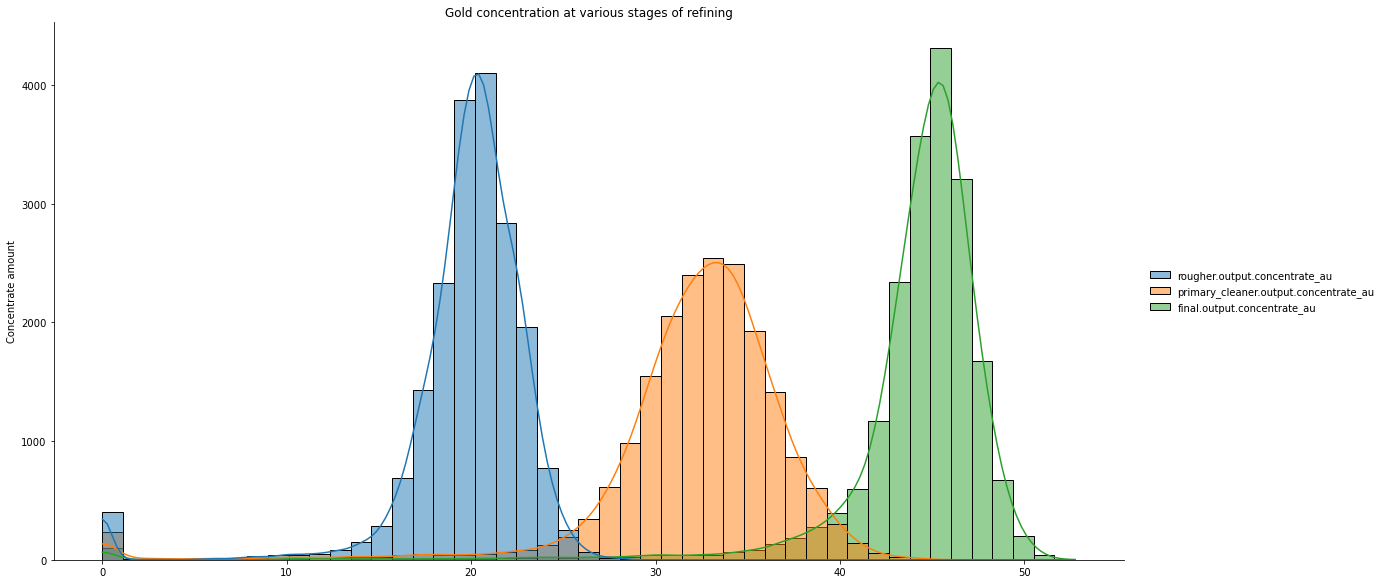

<Figure size 864x576 with 0 Axes>

In [47]:
# plotting for Au:
sns.displot(full_plot[['rougher.output.concentrate_au', 
                  'primary_cleaner.output.concentrate_au',
                  'final.output.concentrate_au']], 
                   height=8, aspect=2, kde = True, legend=True)
plt.title('Gold concentration at various stages of refining')
plt.ylabel('Concentrate amount')
plt.figure(figsize=(12,8))

As can be seen, the concentration of gold actually differs depending on the purification step. At the first stage - flotation ('rougher'), a mixture containing gold ore is fed into the plant, therefore it can be seen that the concentration is quite high (it also contains residues with a low concentration of valuable metals). After the initial cleaning, a lower concentration of gold is obtained from the rough concentrate, and at the final stage, the highest concentration of gold is observed, which is quite logical.

**2. Silver**

<Figure size 864x576 with 0 Axes>

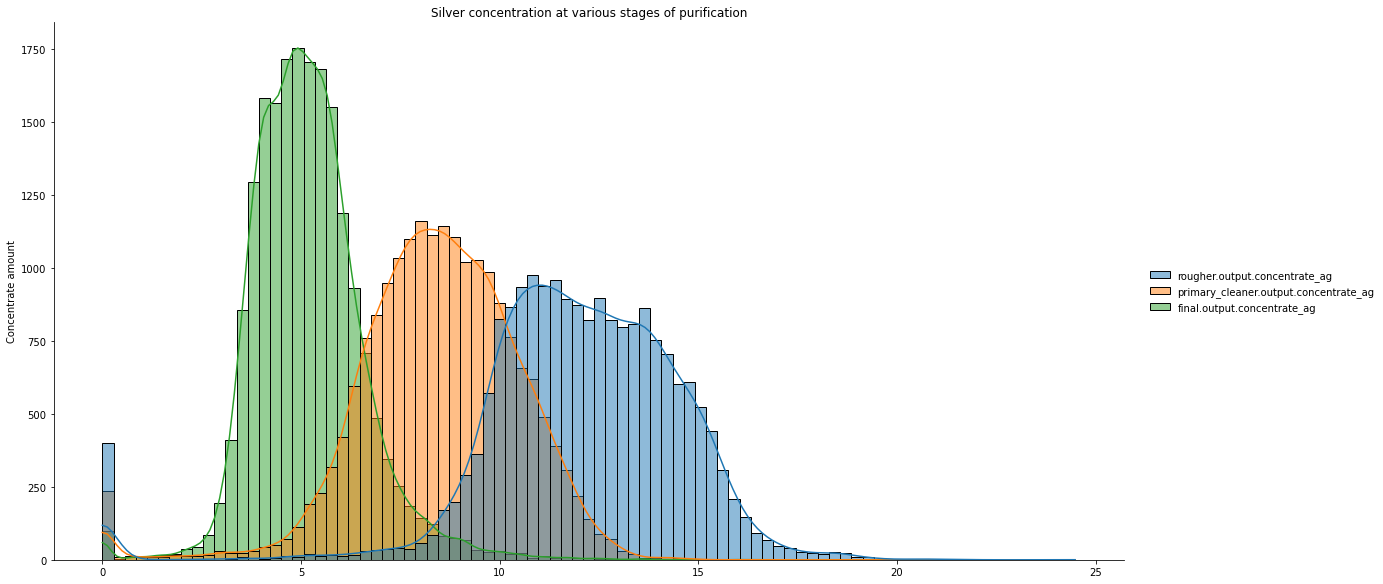

<Figure size 864x576 with 0 Axes>

In [48]:
# plotting for Ag:
sns.displot(full_plot[['rougher.output.concentrate_ag', 
                  'primary_cleaner.output.concentrate_ag',
                  'final.output.concentrate_ag']], 
                   height=8, aspect=2, kde = True, legend=True)
plt.title('Silver concentration at various stages of purification')
plt.ylabel('Concentrate amount')
plt.figure(figsize=(12,8))

Unlike gold, the concentration of silver steadily decreases from the very first stage of purification - flotation to the final concentrate, in which the lowest concentration of precious metal is observed.

**3. Plumbum**

<Figure size 864x576 with 0 Axes>

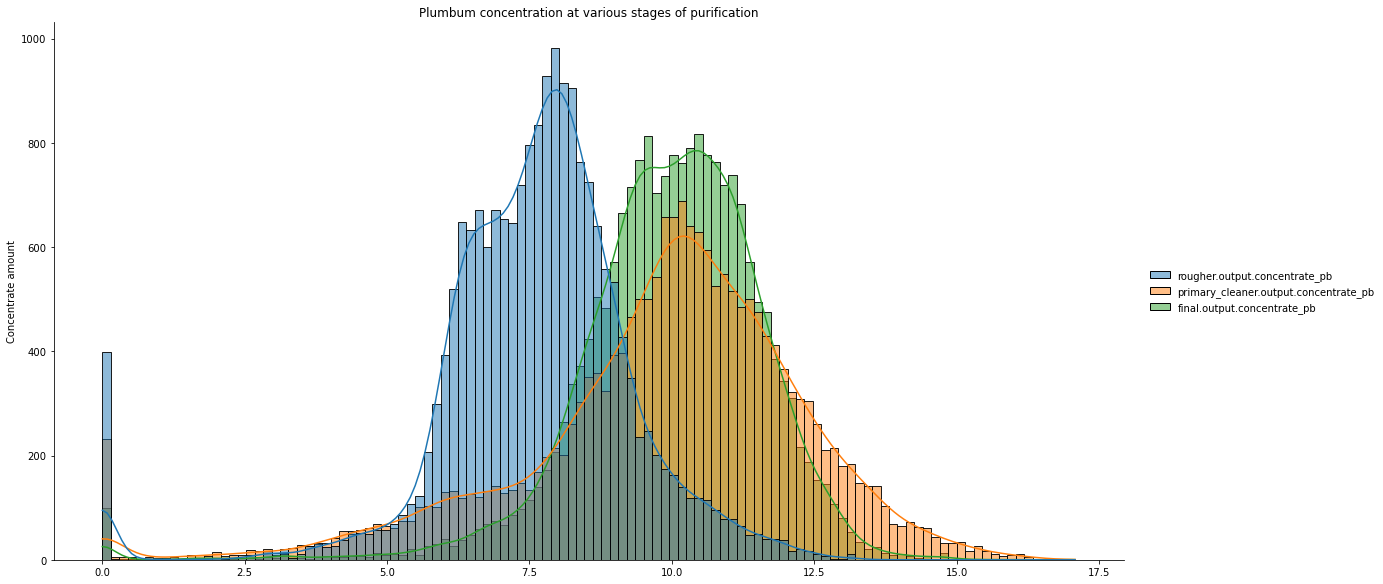

<Figure size 864x576 with 0 Axes>

In [49]:
# plotting for Pb:
sns.displot(full_plot[['rougher.output.concentrate_pb', 
                  'primary_cleaner.output.concentrate_pb',
                  'final.output.concentrate_pb']], 
                   height=8, aspect=2, kde = True, legend=True)
plt.title('Plumbum concentration at various stages of purification')
plt.ylabel('Concentrate amount')
plt.figure(figsize=(12,8))

With regard to plumbum, the highest concentration can be seen in the first stage of processing. After primary purification and at the final stage of treatment, the median concentration values are very similar, but nevertheless, at the very last stage, the lead concentration indicator is higher than after the first stage of treatment.

## Raw material granules' size distribution

If the distributions of the granule sizes of raw materials on the train and test samples are very different from each other, the model estimate will be incorrect. Therefore, it is necessary to check this parameter separately.

To perform this stage of the analysis, we are interested in two variables: 'rougher.input.feed_size' and 'primary_cleaner.input.feed_size' from the test and training samples.

In [50]:
# rougher phase feed size:
rougher_input_feed_size = pd.concat(
    [train_new['rougher.input.feed_size'], 
     test_new['rougher.input.feed_size']], axis=1)

rougher_input_feed_size.columns = ['train', 'test']
rougher_input_feed_size.describe()

,train,test
count,14149.000000,5290.000000
mean,60.062311,55.950131
std,22.309171,19.080083
min,9.659576,0.046369
25%,48.994530,43.906504
50%,55.373885,50.841029
75%,65.918384,62.425276
max,484.967466,392.494040


<Figure size 864x576 with 0 Axes>

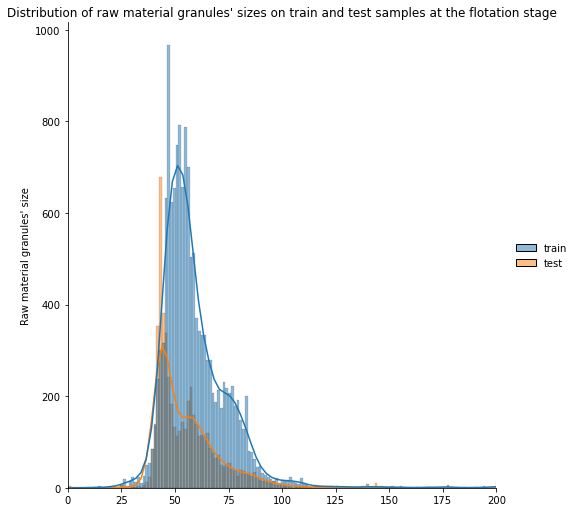

<Figure size 864x576 with 0 Axes>

In [51]:
# plotting distributions
sns.displot(rougher_input_feed_size, 
                   height=7, aspect=1, kde = True, legend=True)
plt.title("Distribution of raw material granules' sizes on train and test samples at the flotation stage")
plt.ylabel("Raw material granules' size")
plt.xlim(0, 200)
plt.figure(figsize=(12,8))

As can be seen, at the rougher stage, the distribution of raw material granules' sizes is quite symmetrical within the train and test samples. Let's see how things are with the sizes of raw material granules at the stage of primary purification:

In [52]:
# primary_cleaner phase feed size:
primary_cleaner_feed_size = pd.concat(
    [train_new['primary_cleaner.input.feed_size'], 
     test_new['primary_cleaner.input.feed_size']], axis=1)

primary_cleaner_feed_size.columns = ['train', 'test']
primary_cleaner_feed_size.describe()

,train,test
count,14149.000000,5290.000000
mean,7.322310,7.266339
std,0.614062,0.610219
min,1.080000,5.650000
25%,6.960000,6.890000
50%,7.290000,7.250000
75%,7.700000,7.600000
max,10.470000,15.500000


<Figure size 864x576 with 0 Axes>

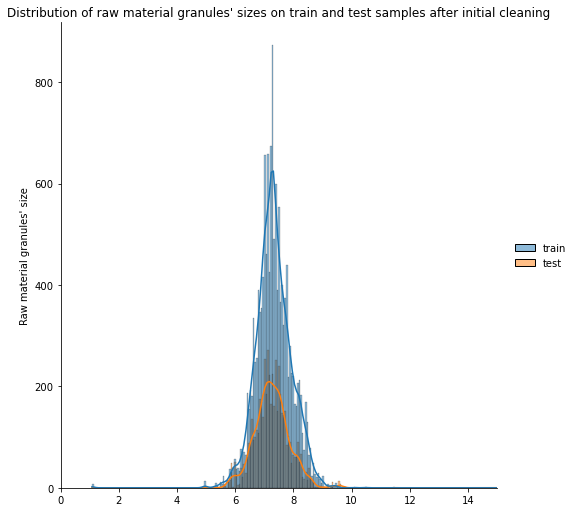

<Figure size 864x576 with 0 Axes>

In [53]:
# plotting distributions
sns.displot(primary_cleaner_feed_size, 
                   height=7, aspect=1, kde = True, legend=True)
plt.title("Distribution of raw material granules' sizes on train and test samples after initial cleaning")
plt.ylabel("Raw material granules' size")
plt.xlim(0, 15)
plt.figure(figsize=(12,8))

As in the previous case, the distributions in the train and test samples are very similar, which allows us to continue further work with these data.

## Study of the total concentration of all substances¶

Let's analyze the total concentration of all substances at different stages: in raw materials, in rough and final concentrates. To work with this task, I suggest using the initial data from the 'full' table.

In [54]:
# calculation of the final concentrate at various stages:
full['raw_sum'] = full[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
full['rough_concentrate_sum'] = full[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
full['final_concentrate_sum'] = full[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)
full[['raw_sum', 'rough_concentrate_sum', 'final_concentrate_sum']].describe()

,raw_sum,rough_concentrate_sum,final_concentrate_sum
count,19439.000000,19439.000000,19439.000000
mean,20.640600,39.373032,59.223099
std,4.494362,6.863389,6.097603
min,0.030000,0.000000,0.000000
25%,17.252879,38.394639,59.298323
50%,20.141216,40.312648,60.306921
75%,23.797381,42.365102,61.096667
max,33.498784,55.568687,64.968881


In [55]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 90 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


<Figure size 1080x504 with 0 Axes>

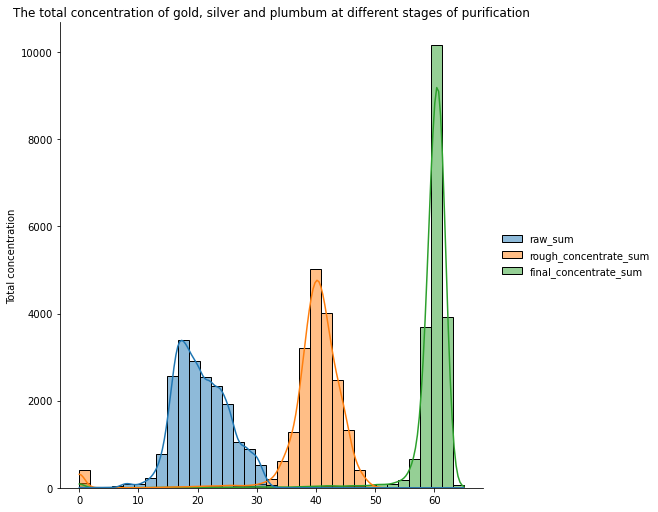

<Figure size 1080x504 with 0 Axes>

In [56]:
# plotting distributions
sns.displot(full[['raw_sum', 
                  'rough_concentrate_sum', 
                  'final_concentrate_sum']], 
                   height=7, aspect=1, kde = True, legend=True)
plt.title('The total concentration of gold, silver and plumbum at different stages of purification')
plt.ylabel('Total concentration')
plt.figure(figsize=(15,7))

So, from the graph it follows that the total concentration of the precious substance increases from the first to the last stage of purification: the minimum concentration is observed in the raw material, and the maximum concentration is in the final product.

If we talk about distribution, then attention is drawn to the presence of outliers at each of the stages in the region of zero values, let's look in more detail:

<Figure size 1080x504 with 0 Axes>

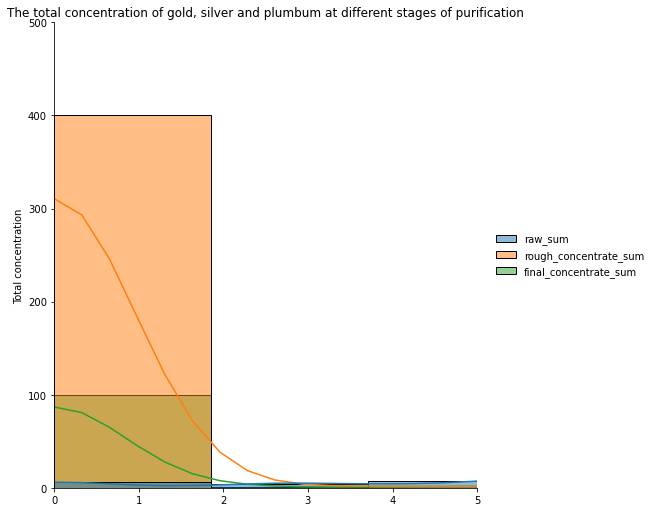

<Figure size 1080x504 with 0 Axes>

In [57]:
# plotting distributions
sns.displot(full[['raw_sum', 
                  'rough_concentrate_sum', 
                  'final_concentrate_sum']], 
                   height=7, aspect=1, kde = True, legend=True)
plt.title('The total concentration of gold, silver and plumbum at different stages of purification')
plt.ylabel('Total concentration')
plt.xlim(0,5)
plt.ylim(0,500)
plt.figure(figsize=(15,7))

As can be seen, each of the cleaning stages has outliers equal to zero concentration of precious metals. These emissions reflect the actual concentration of substances. And it is important for us that the model is able to see and process the zero concentration as well, so it makes no practical sense to remove these outliers from the data and can worsen the usefulness of the model.

Summing up the data analysis stage, the following work was done:

- the analysis of the concentration of gold, silver and plumbum at various stages of processing was carried out. This analysis showed that the concentration of gold increases towards the final stage of processing, while the concentration of silver and plumbum decreases. At the same time, the concentration of the precious substance in plumbum is quite similar at the second and final stages of processing;
- the distribution of the granules' sizes of raw materials in the test and training samples was investigated, which showed an almost identical distribution, which allows further work with the provided samples;
- the total concentration of all substances at various stages of metal processing was analyzed. This stage made it possible to reveal the presence of outliers with a value of metal concentration at each of the processing stages <1. Removing such observations has been treated as unnecessary.

## Model training

First, let's write a function for calculating the final quality metric - sMAPE

In [62]:
def smape(target, predictions):
    numerator = abs(predictions - target)
    denominator = (abs(target) + abs(predictions)) / 2
    total = (numerator / denominator).sum()
    smape = 1 / len(target) * total * 100
    return smape

Based on the fact that there is need to predict a continuous variable, I propose to test the prediction of three models:
- Decision Tree Regressor;
- Random Forest Regressor;
- Linear Regression.

**Let's prepare the variables:**

In [59]:
# variables for train sample:
features_train = train_new.drop(
    ['rougher.output.recovery', 
     'final.output.recovery', 'date'], axis=1)

target_train_rougher = train_new['rougher.output.recovery']
target_train_final = train_new['final.output.recovery']

# variables for test sample:
features_test = test_new.drop(
    ['rougher.output.recovery', 
     'final.output.recovery', 'date'], axis=1)

target_test_rougher = test_new['rougher.output.recovery']
target_test_final = test_new['final.output.recovery']

#Checking the shapes of new variables:
print(features_train.shape)
print(target_train_rougher.shape)
print(target_train_final.shape)
print(features_test.shape)
print(target_test_rougher.shape)
print(target_test_final.shape)

(14149, 52)
(14149,)
(14149,)
(5290, 52)
(5290,)
(5290,)


**Feature scaling**

In [60]:
numeric = features_train.columns

scaler = StandardScaler()
scaler.fit(features_train[numeric])

# train sample:
features_train[numeric] = scaler.transform(features_train[numeric])

# test sample:
features_test[numeric] = scaler.transform(features_test[numeric]) 

# transformation results on the training sample:
features_train.head(5)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,-0.158067,0.376181,-0.117761,0.277744,-0.453547,-0.283903,-0.436151,-0.810390,-0.439503,-0.254349,...,-1.055213,-0.468922,-0.644513,-0.756008,-1.174583,-0.378806,-0.864642,-0.420945,-0.941436,-2.671329
1,-0.195191,0.426199,-0.117761,0.315183,-0.247965,-0.339721,-0.249131,-0.318233,-0.244942,-0.272555,...,-1.059554,-0.528356,-0.672941,-0.698489,-1.155101,-0.427889,-0.881104,-0.423781,-0.967979,-2.508024
2,-0.241113,0.729970,-0.117761,0.284493,-0.050184,-0.314311,-0.062723,-0.340312,-0.051208,-0.316207,...,-1.055535,-0.469570,-0.680124,-0.695122,-1.149670,-0.426811,-0.876053,-0.422133,-0.962720,-2.552261
3,-0.280441,0.731715,-0.117761,0.299231,-0.062550,-0.341032,-0.060644,-0.312615,-0.063866,-0.312219,...,-1.051735,-0.436779,-0.663614,-0.696146,-1.166912,-0.402332,-0.882394,-0.415459,-0.966730,-2.513659
4,-0.389115,0.907858,-0.117761,0.334587,-0.051870,-0.285676,-0.054705,-0.331844,-0.069246,-0.316715,...,-1.053363,-0.416700,-0.672458,-0.693771,-1.174570,-0.467918,-0.896804,-0.418013,-0.968275,-2.554131


**Cross validation for Linear Regression:**

In [63]:
scorer = make_scorer(smape, greater_is_better=False) 
lr_model = LinearRegression()
lr_score_rougher = cross_val_score(lr_model, features_train, 
                                   target_train_rougher, 
                                   cv=5, scoring=scorer).mean()
lr_score_final = cross_val_score(lr_model, features_train, 
                                 target_train_final, cv=5,
                                 scoring=scorer).mean()
print('Linear regression estimates for targets:', lr_score_rougher, lr_score_final)
print('Final score for linear regression:', 
      0.25 * lr_score_rougher + 0.75 * lr_score_final)

Linear Regression estimates for targets: -12.5320029839115 -12.698441529739451
Final score for linear regression: -12.656831893282462


**Cross validation for Decision Tree:**

In [64]:
scorer = make_scorer(smape, greater_is_better=False) 
tree_model = DecisionTreeRegressor(random_state = 12345)
tree_score_rougher = cross_val_score(tree_model, features_train, 
                                    target_train_rougher, cv=5,
                                    scoring=scorer).mean()
tree_score_final = cross_val_score(tree_model, features_train, 
                                   target_train_final, cv=5,
                                   scoring=scorer).mean()
print('Decision tree estimates for targets', tree_score_rougher, tree_score_final)
print('Final score for decision tree:', 
      0.25 * tree_score_rougher + 0.75 * tree_score_final)

Decision tree estimates for targets -23.11717237647901 -17.63779612316093
Final score for decision tree: -19.00764018649045


**Cross validation for Random Forest:**

In [65]:
%%time
scorer = make_scorer(smape, greater_is_better=False) 
forest_model = RandomForestRegressor(random_state=12345, 
                                     n_estimators = 30)
forest_score_rougher = cross_val_score(forest_model, features_train, 
                                    target_train_rougher, cv=5,
                                    scoring=scorer).mean()
forest_score_final = cross_val_score(forest_model, features_train, 
                                   target_train_final, cv=5,
                                   scoring=scorer).mean()
print('Random forest estimates for targets:', forest_score_rougher, forest_score_final)
print('Final score for random forest:', 
      0.25 * forest_score_rougher + 0.75 * forest_score_final)

Random forest estimates for targets: -14.120883168902987 -12.228450375260309
Final score for random forest: -12.701558573670978
CPU times: user 2min 10s, sys: 276 ms, total: 2min 10s
Wall time: 2min 10s


As can be seen from the results of cross-validation, judging by the value of the final sMAPE, the Random Forest model shows the best result. I propose to dwell on it and use it for further selection of hyperparameters and verification on a test sample.

**Selection of hyperparameters for Random Forest:**

In [66]:
%%time
best_model = None
best_result = 0
result = []
for depth in range(1,10):
     for est in range(10, 25, 5):
        forest_model =  RandomForestRegressor(random_state=12345, n_estimators=est, 
                                              max_depth = depth) 
        scorer = make_scorer(smape, greater_is_better=False) 
        forest_score_rougher = cross_val_score(forest_model, 
                                               features_train, 
                                               target_train_rougher, 
                                               cv=5,
                                               scoring=scorer).mean()
        forest_score_final = cross_val_score(forest_model, 
                                             features_train, 
                                             target_train_final, 
                                             cv=5,
                                             scoring=scorer).mean()
        smape_final_score = 0.25 * forest_score_rougher + 0.75 * forest_score_final
        if smape_final_score > best_result:
            best_model = forest_model
            best_result = smape_final_score
        result.append({'n_estimators': est, 
                        'max_depth': depth, 
                        'smape_final_result': smape_final_score})
        
pd.DataFrame(result).style.highlight_max('smape_final_result', color = 'lightgreen', axis = 0)

CPU times: user 8min 31s, sys: 898 ms, total: 8min 32s
Wall time: 8min 32s


,n_estimators,max_depth,smape_final_result
0,10,1,-11.265553
1,15,1,-11.260349
2,20,1,-11.261436
3,10,2,-10.933414
4,15,2,-10.903556
5,20,2,-10.867584
6,10,3,-10.621536
7,15,3,-10.614537
8,20,3,-10.572127
9,10,4,-10.613048


So, the best value of the sMAPE metric (-10.423317) was achieved with the following parameters:

- n_estimators = 20
- max_depth = 5

**Let's train the training model and test it on a test set:**

In [67]:
final_model = RandomForestRegressor(random_state=12345, 
                                       n_estimators=20, 
                                       max_depth=5)
# rougher:
final_model.fit(features_train, target_train_rougher)
predict_rougher = final_model.predict(features_test)

# final
final_model.fit(features_train, target_train_final)
predict_final = final_model.predict(features_test)

smape_rougher = smape(target_test_rougher, predict_rougher)
smape_final = smape(target_test_final, predict_final)

print('Final sMAPE value on the test sample:', (0.25 * smape_rougher + 0.75 * smape_final))

Final sMAPE value on the test sample: 9.554580386245485


**Checking the result of the test model for sanity:**

In [68]:
dummy_mean = DummyRegressor(strategy = 'mean').fit(features_train, target_train_rougher)

# rougher
predict_dummy_rougher = dummy_mean.predict(features_test)
smape_dummy_rougher = smape(target_test_rougher, predict_dummy_rougher)

# final
dummy_mean = DummyRegressor(strategy = 'mean').fit(features_train, target_train_final) # ВОТ ЗДЕСЬ ОПИСКА !!!!!!!!!!!!!!!!!!!
predict_dummy_final = dummy_mean.predict(features_test)
smape_dummy_final = smape(target_test_final, predict_dummy_final)

print('Final sMAPE value on dummy sample:', (0.25 * smape_dummy_rougher + 0.75 * smape_dummy_final))

Final sMAPE value on dummy sample: 10.289630376021034


As can be seen from the test results: the model error on a constant sample turns out to be greater than the error on the test sample: 10.3% and 9.5%, respectively. This may indicate a better quality of our model.

Thus, in this part of the work, the following tasks were implemented:

- a function was written to calculate the quality metric - Symmetric Mean Absolute Percentage Error (sMAPE);
- using cross-validation, the quality of predictions of logistic regression, decision tree and random forest was checked. The best result of the quality metric was achieved using the random forest model;
- using the hyperparameter selection function, it was possible to find out at which values of n_estimators and max_depth a random forest achieves the smallest sMAPE value. The resulting hyperparameters were used for the final training of the model;
- the constructed model was tested on test data. It was possible to achieve the sMAPE indicator equal to 9.5% of errors, while the constant model shows a value of 10.3%, which indicates a higher quality of the constructed model. But it is still worth revising some parameters in the future and finding ways to improve the quality of the prediction model.

## Conclusion

Based on the results of the work done, it was possible to build a prototype of the model, which can be used in the future to predict the recovery factors of gold from gold-bearing raw materials (ore).

Preprocessing, data analysis and model building allowed to train the Random Forest model, the quality metric of which (sMAPE metric) shows an error of only 9.5%, while the constant model shows an error of 10.3%.